In [ ]:
!pip install yfinance

In [ ]:
!pip install pmdarima

In [3]:
# Importando librerías
import numpy as np
import matplotlib. pyplot as plt
import pandas as pd
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

# Importar datos desde Drive

In [4]:
# Importar el fichero .PY, el cual se conecta a Yahoo Finance e importa los datos
from google.colab import drive
drive.mount('/content/drive')

execfile('/content/drive/MyDrive/StockPrediction/import_data_stock_prediction.py')

Mounted at /content/drive


In [5]:
tickerSymbol = 'AAPL'

# Obtenemos los datos desde el día actual hasta hace 5 años
one_year_ago = datetime.now() - relativedelta(years=5)
start_date = one_year_ago.strftime('%Y-%m-%d')

#one_year_ago = datetime.now() - relativedelta(years=1)
end_date = datetime.now().strftime('%Y-%m-%d')

# Se obtiene el datafram de la empresa seleccionada y en el rango de fechas
tickerDf = GetStockDataByTicker(tickerSymbol, start_date, end_date)

# ARIMA

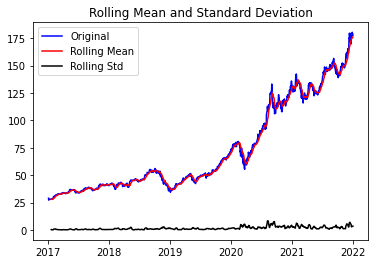

Results of dickey fuller test
Test Statistics                   1.206480
p-value                           0.996030
No. of lags used                 20.000000
Number of observations used    1238.000000
critical value (1%)              -3.435643
critical value (5%)              -2.863877
critical value (10%)             -2.568014
dtype: float64


In [6]:
from statsmodels.tsa.stattools import adfuller

#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(tickerDf['Adj Close'])

<Figure size 432x288 with 0 Axes>

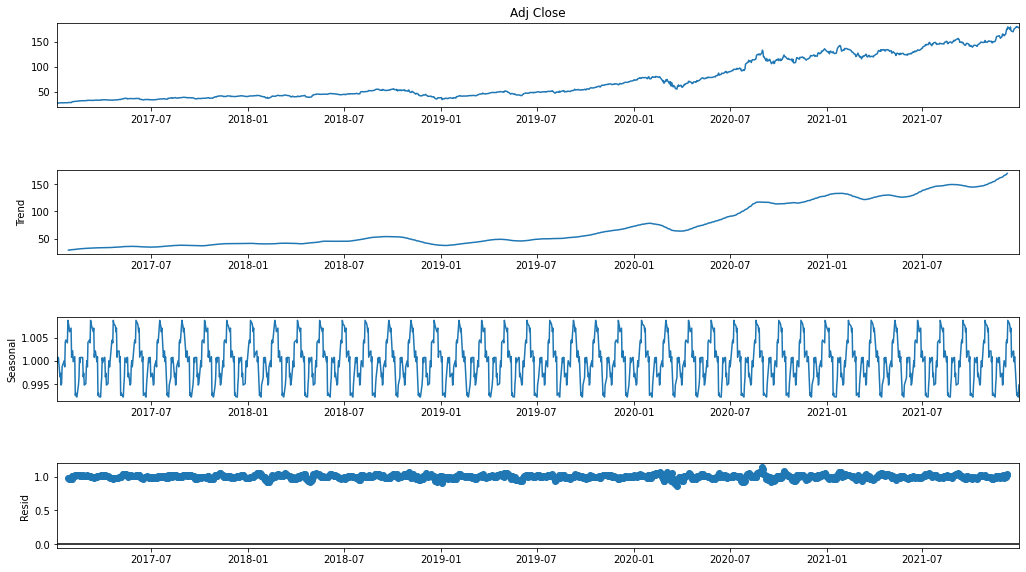

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(tickerDf['Adj Close'], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


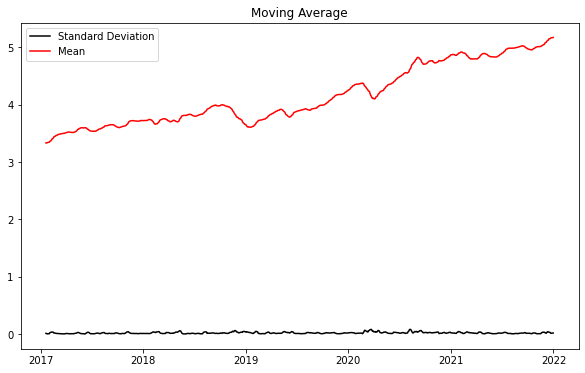

In [8]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(tickerDf['Adj Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

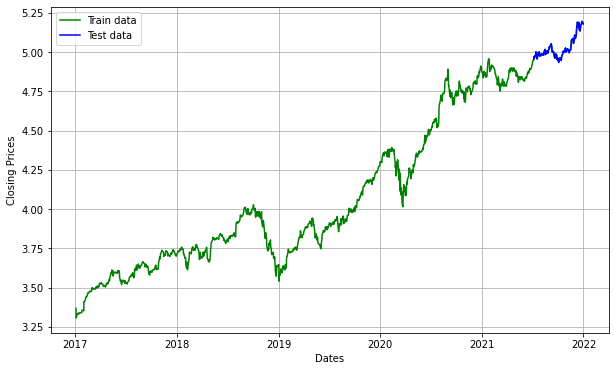

In [9]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5659.060, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5678.854, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5677.864, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5655.123, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5677.106, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5677.129, Time=1.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5675.067, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5673.089, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 4.435 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1130
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2842.427
Date:                Sun, 02 Jan 2022   AIC                          -5678.854
Time:                       

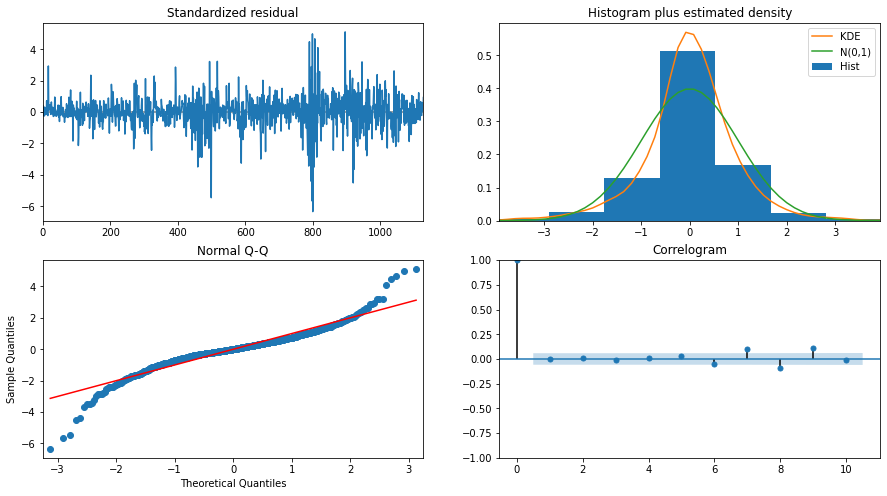

In [10]:
from pmdarima.arima import auto_arima

# ARIMA
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [11]:
from statsmodels.tsa.arima.model import ARIMA

#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1130
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2828.561
Date:                Sun, 02 Jan 2022   AIC                          -5655.123
Time:                        19:33:17   BIC                          -5650.094
Sample:                             0   HQIC                         -5653.223
                               - 1130                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   7.88e-06     49.492      0.000       0.000       0.000
Ljung-Box (L1) (Q):                  21.64   Jarque-Bera (JB):              2224.59
Prob(Q):                              0.00   Pr

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [12]:
# Forecast
# train_data.index = pd.DatetimeIndex(train_data.index).to_period('D')
fc = fitted.forecast(len(test_data.index), alpha=0.05)
#fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


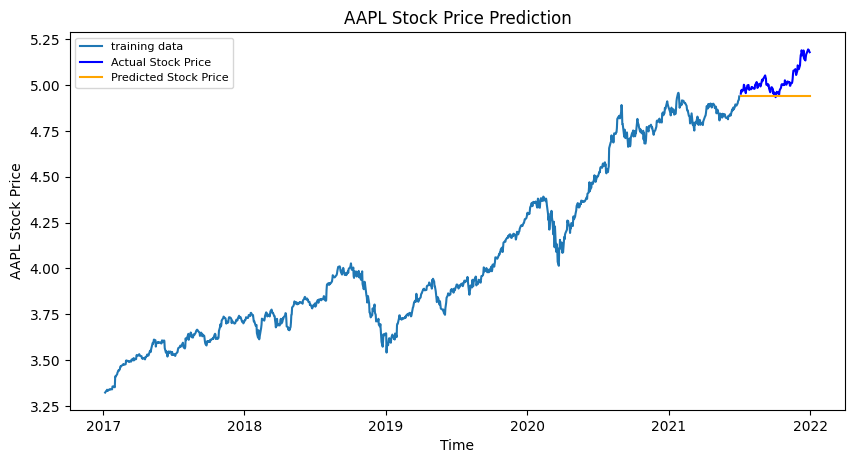

In [15]:
# Make as pandas series
fc_series = pd.Series(fc.values, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [14]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.012306861990460712
MAE: 0.08751724105119611
RMSE: 0.11093629699273684
MAPE: nan


/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:3522: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects
  join_index = self.union(other)
